In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import random
import io 
import PIL 
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
cpu = hoomd.device.CPU()

In [26]:
simulation = hoomd.Simulation(device=cpu, seed=17)

In [27]:
simulation.create_state_from_gsd(filename='lattice_sq_v4.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_expansion_v4_exp2.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion_v4_exp2.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [28]:
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

In [30]:
s = 2  # Assuming the side length of the square is 2 units
volume_particle = s ** 2

beta_P = 3

In [31]:
boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=-2
)
simulation.operations.updaters.append(boxmc)

# Add tuners for optimization
tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

In [9]:
# Arrays to store results
all_volume_fractions = []  # To store volume fractions for each pressure
pressure_values = []       # To store the corresponding pressures
stabilized_avg_vf = []     # To store stabilized average volume fraction
stabilized_std_vf = []     # To store standard deviation of stabilized volume fractions

# Simulation loop over pressures
for beta_P in numpy.arange(40, 20, -1):  # From 20 to 10
    print(f"Running simulation for beta_P = {beta_P}...")
    
    # Update the pressure
    boxmc.betaP = beta_P
    
    # Reset volume fraction tracking
    volume_fractions = []
    timesteps = []
    
    # Run the simulation for this pressure
    run_steps = 2_000_000
    log_interval = 1_00  # Log every 100 steps
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
        volume_fractions.append(current_vf)
        timesteps.append(step)
    
    # Store results for this pressure
    all_volume_fractions.append(volume_fractions)
    pressure_values.append(beta_P)
    
    # Calculate stabilization metrics
    std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
    avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])
    
    stabilized_avg_vf.append(avg)
    stabilized_std_vf.append(std)
    
    print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

print("Simulation complete for all pressures.")


Running simulation for beta_P = 40...
  Stabilized Volume Fraction: 0.98363, Std Dev: 0.00074
Running simulation for beta_P = 39...
  Stabilized Volume Fraction: 0.97908, Std Dev: 0.00129
Running simulation for beta_P = 38...
  Stabilized Volume Fraction: 0.98211, Std Dev: 0.00079
Running simulation for beta_P = 37...
  Stabilized Volume Fraction: 0.97835, Std Dev: 0.00108
Running simulation for beta_P = 36...
  Stabilized Volume Fraction: 0.97912, Std Dev: 0.00108
Running simulation for beta_P = 35...
  Stabilized Volume Fraction: 0.97975, Std Dev: 0.00133
Running simulation for beta_P = 34...
  Stabilized Volume Fraction: 0.97851, Std Dev: 0.00130
Running simulation for beta_P = 33...
  Stabilized Volume Fraction: 0.97806, Std Dev: 0.00110
Running simulation for beta_P = 32...
  Stabilized Volume Fraction: 0.97584, Std Dev: 0.00154
Running simulation for beta_P = 31...
  Stabilized Volume Fraction: 0.97526, Std Dev: 0.00091
Running simulation for beta_P = 30...
  Stabilized Volume Fr

In [21]:
gsd_writer.flush()

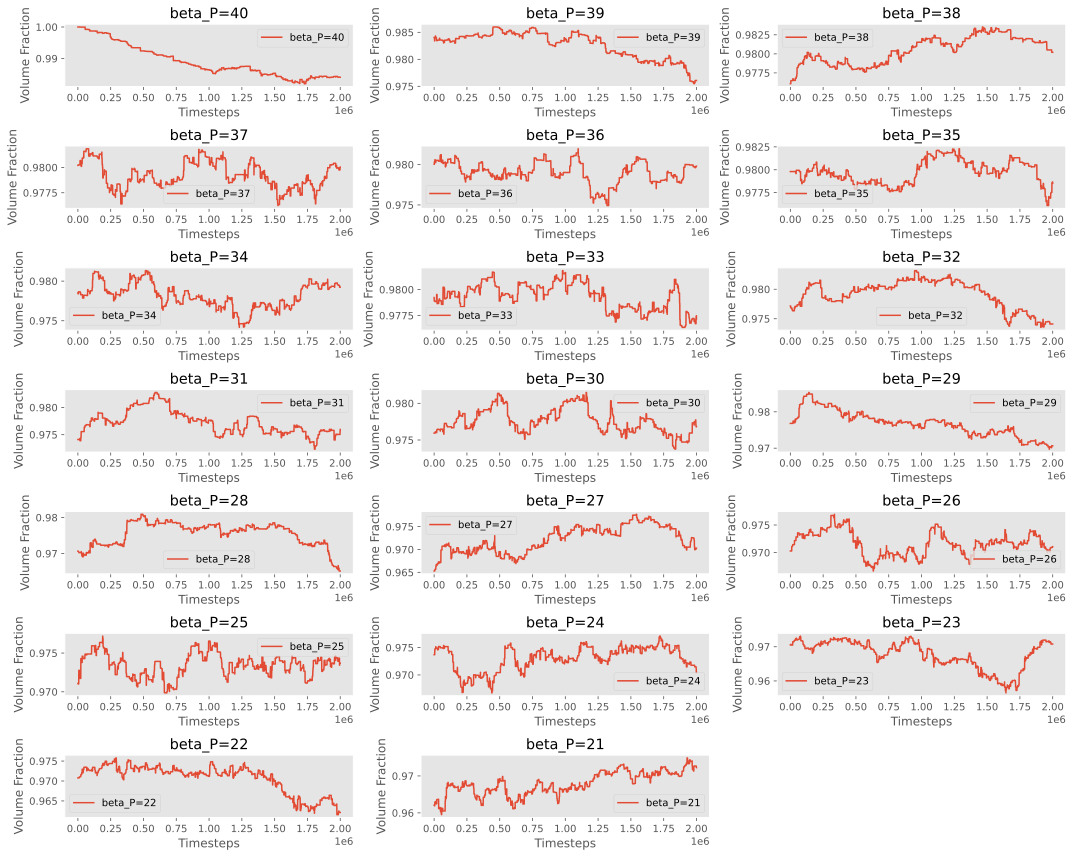

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid dimensions (adjust based on the number of pressures)
n_rows = 7  # Number of rows in the collage
n_cols = 3  # Number of columns in the collage

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()  # Flatten for easier iteration

# Loop over each pressure and corresponding subplot
for i, beta_P in enumerate(np.arange(40, 20, -1)):  # Adjust as needed
    ax = axes[i]
    
    timesteps = range(0, len(all_volume_fractions[i]) * log_interval, log_interval)
    ax.plot(timesteps, all_volume_fractions[i], label=f"beta_P={beta_P}")
    
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Volume Fraction")
    ax.set_title(f"beta_P={beta_P}")
    ax.grid()
    ax.legend()

# Remove any empty subplots (if there are more axes than pressures)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


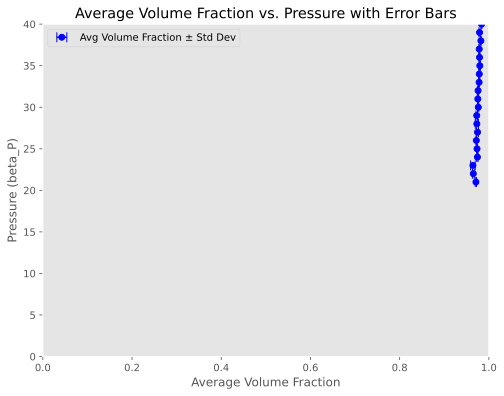

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert pressures and average volume fractions into numpy arrays for better handling
pressures = np.arange(40, 20, -1)  # From 20 to 11
avg_volume_fractions = np.array(stabilized_avg_vf)
std_volume_fractions = np.array(stabilized_std_vf)

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    avg_volume_fractions, pressures, xerr=std_volume_fractions, fmt='o', 
    capsize=5, label='Avg Volume Fraction ± Std Dev', color='b'
)

plt.xlabel("Average Volume Fraction")
plt.ylabel("Pressure (beta_P)")
plt.title("Average Volume Fraction vs. Pressure with Error Bars")
plt.xlim(0,1)
plt.ylim(0,40)
plt.grid()
plt.legend()
plt.show()


In [25]:
import numpy as np
import json

# Convert numpy.int64 values to standard Python int type
pressure_values = [int(p) for p in pressure_values]
stabilized_avg_vf = [float(avg) for avg in stabilized_avg_vf]
stabilized_std_vf = [float(std) for std in stabilized_std_vf]

# Data from simulation 1 (assuming these are now standard Python types)
data_40_to_20 = {
    "pressures": pressure_values,  # Now all are Python ints
    "avg_vf": stabilized_avg_vf,    # These should be Python floats
    "std_vf": stabilized_std_vf     # These should be Python floats
}

# Save to JSON file
with open('simulation_40_to_20.json', 'w') as f:
    json.dump(data_40_to_20, f)


In [ ]:
############################
############################
############################
############################
############################
############################
############################
############################
############################
############################

In [32]:
# Arrays to store results
all_volume_fractions = []  # To store volume fractions for each pressure
pressure_values = []       # To store the corresponding pressures
stabilized_avg_vf = []     # To store stabilized average volume fraction
stabilized_std_vf = []     # To store standard deviation of stabilized volume fractions

# Simulation loop over pressures
for beta_P in numpy.arange(3, 1, -0.2):  
    print(f"Running simulation for beta_P = {beta_P}...")
    
    # Update the pressure
    boxmc.betaP = beta_P
    
    # Reset volume fraction tracking
    volume_fractions = []
    timesteps = []
    
    # Run the simulation for this pressure
    run_steps = 2_000_000
    log_interval = 1_00  # Log every 100 steps
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
        volume_fractions.append(current_vf)
        timesteps.append(step)
    
    # Store results for this pressure
    all_volume_fractions.append(volume_fractions)
    pressure_values.append(beta_P)
    
    # Calculate stabilization metrics
    std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
    avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])
    
    stabilized_avg_vf.append(avg)
    stabilized_std_vf.append(std)
    
    print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

print("Simulation complete for all pressures.")


Running simulation for beta_P = 3.0...
  Stabilized Volume Fraction: 0.81454, Std Dev: 0.01669
Running simulation for beta_P = 2.8...
  Stabilized Volume Fraction: 0.80946, Std Dev: 0.01788
Running simulation for beta_P = 2.5999999999999996...
  Stabilized Volume Fraction: 0.79400, Std Dev: 0.02377
Running simulation for beta_P = 2.3999999999999995...
  Stabilized Volume Fraction: 0.77126, Std Dev: 0.01819
Running simulation for beta_P = 2.1999999999999993...
  Stabilized Volume Fraction: 0.75331, Std Dev: 0.02032
Running simulation for beta_P = 1.9999999999999991...
  Stabilized Volume Fraction: 0.73352, Std Dev: 0.01810
Running simulation for beta_P = 1.799999999999999...
  Stabilized Volume Fraction: 0.69742, Std Dev: 0.01651
Running simulation for beta_P = 1.5999999999999988...
  Stabilized Volume Fraction: 0.66757, Std Dev: 0.02496
Running simulation for beta_P = 1.3999999999999986...
  Stabilized Volume Fraction: 0.63238, Std Dev: 0.02576
Running simulation for beta_P = 1.1999999

In [33]:
import numpy as np
import json

# Convert numpy.int64 values to standard Python int type
pressure_values = [int(p) for p in pressure_values]
stabilized_avg_vf = [float(avg) for avg in stabilized_avg_vf]
stabilized_std_vf = [float(std) for std in stabilized_std_vf]

# Data from simulation 1 (assuming these are now standard Python types)
data_40_to_20 = {
    "pressures": pressure_values,  # Now all are Python ints
    "avg_vf": stabilized_avg_vf,    # These should be Python floats
    "std_vf": stabilized_std_vf     # These should be Python floats
}

# Save to JSON file
with open('simulation_40_to_20_v2.json', 'w') as f:
    json.dump(data_40_to_20, f)
